## DeepAR Model - Predict Bike Rental with Dynamic Features

Note: This dataset is not a true timeseries as there a lot of gaps

We have data only for first 20 days of each month and model needs to predict the rentals for 
the remaining days of the month. The dataset consists of two years data. DeepAR will shine with true multiple-timeseries dataset like the electricity example given below

In [5]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import datetime

import boto3
import sagemaker
from sagemaker import get_execution_role

In [113]:
# Provide endpoint
with_categories = False
endpoint_name = 'deepar-AAPL-with-dynamic-feat-2021-01-01-22-59-06-303'

In [114]:
freq='D' # Timeseries consists Hourly Data and we need to predict hourly rental count

# how far in the future predictions can be made
# 12 days worth of hourly forecast 
prediction_length = 5 

# aws recommends setting context same as prediction length as a starting point. 
# This controls how far in the past the network can see
context_length = 5

In [115]:
df = pd.read_csv('all_data_dynamic_feat.csv', parse_dates=[0],index_col=0)
#df_test = pd.read_csv('test.csv', parse_dates=['datetime'],index_col=0) # data points to be predicted for submission
#resampling changes order, so it needs to be done
df = df.resample('1d').mean()

In [116]:
df.head()

,Close/Last,Volume,Open,High,Low
datetime,,,,,
2019-12-23,71.000,9.871152e+07,70.132,71.062,70.093
2019-12-24,71.068,4.847884e+07,71.172,71.222,70.730
2019-12-25,71.808,5.266450e+07,71.033,71.694,70.877
2019-12-26,72.478,9.333600e+07,71.205,72.495,71.175
2019-12-27,72.450,1.463718e+08,72.780,73.492,72.030


In [117]:
mn=df.index.min()
mx=df.index.max()
mn,mx

(Timestamp('2019-12-23 00:00:00', freq='D'),
 Timestamp('2020-12-22 00:00:00', freq='D'))

In [118]:
dt_predict_max = pd.Timestamp(mx, freq=freq) # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)

dt_dataset_start_time = pd.Timestamp(mn, freq=freq)
dt_dataset_end_time = pd.Timestamp(mx, freq=freq)

# use for model training
# Training TS end time ensures some data is withheld for model testing
# 5 days worth of training data is withheld for testing
dt_train_range = (dt_dataset_start_time,
                  dt_dataset_end_time - datetime.timedelta(days=5) )

# Use entire data for testing
# We can compare predicted values vs actual (i.e. last 5 days is withheld for testing and model hasn't seen that data)
dt_test_range = (dt_dataset_start_time, 
                 dt_dataset_end_time) 
dt_train_range,dt_test_range

((Timestamp('2019-12-23 00:00:00', freq='D'),
  Timestamp('2020-12-17 00:00:00', freq='D')),
 (Timestamp('2019-12-23 00:00:00', freq='D'),
  Timestamp('2020-12-22 00:00:00', freq='D')))

In [119]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [120]:
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))      

In [121]:
# SDK 2. RealTimePredictor renamed to Predictor
class DeepARPredictor(sagemaker.predictor.Predictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        #prediction_times = [x.index[-1]+1 for x in ts]
        prediction_times = [x.index[-1] + datetime.timedelta(days=1) for x in ts] 
        
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k], 
                                   cat[k] if cat else None,
                                   dynamic_feat) 
                     for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            #prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)            
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [122]:
# SDK 2 parameter name endpoint_name, content_type is specified as part of the serializer
predictor = DeepARPredictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session
)

predictor.set_prediction_parameters(freq, prediction_length)
predictor.serializer.content_type = "application/json"

In [123]:
dynamic_features = ['Volume', 'Open', 'High', 'Low']
target_values = ['Close/Last']
df_dynamic_feat = df[dynamic_features]


time_series_test = []
time_series_training = []

for t in target_values:
    time_series_test.append(df[dt_test_range[0]:dt_test_range[1]][t])
    time_series_training.append(df[dt_train_range[0]:dt_train_range[1]][t])
    

#df_dynamic_feat = df[dynamic_features]
dynamic_features_test = df_dynamic_feat[dt_test_range[0]:dt_test_range[1]]
dynamic_features_training = df_dynamic_feat[dt_train_range[0]:dt_train_range[1]]

In [124]:
time_series_test

[datetime
 2019-12-23     71.000
 2019-12-24     71.068
 2019-12-25     71.808
 2019-12-26     72.478
 2019-12-27     72.450
                ...   
 2020-12-18    126.655
 2020-12-19    125.525
 2020-12-20    126.103
 2020-12-21    128.230
 2020-12-22    131.880
 Freq: D, Name: Close/Last, Length: 366, dtype: float64]

In [125]:
dynamic_features_test

,Volume,Open,High,Low
datetime,,,,
2019-12-23,9.871152e+07,70.132,71.062,70.093
2019-12-24,4.847884e+07,71.172,71.222,70.730
2019-12-25,5.266450e+07,71.033,71.694,70.877
2019-12-26,9.333600e+07,71.205,72.495,71.175
2019-12-27,1.463718e+08,72.780,73.492,72.030
...,...,...,...,...
2020-12-18,1.925415e+08,128.960,129.100,126.120
2020-12-19,2.116398e+08,126.985,127.724,123.610
2020-12-20,1.428517e+08,123.792,126.280,121.619


In [126]:
# Provide 0 based index for categories
list_of_df = predictor.predict(time_series_training,
                               cat=[[0],[1],[2]] if with_categories else None,
                               dynamic_feat=dynamic_features_test)

In [127]:
for i in range(len(list_of_df)):
    
    print(list_of_df[i])

                   0.1         0.9         0.5
2020-12-18  122.341148  131.430771  127.004807
2020-12-19  122.790474  130.531281  126.742157
2020-12-20  122.186310  132.296570  126.980820
2020-12-21  121.888176  131.567871  127.160233
2020-12-22  121.873932  130.712997  126.937424


In [128]:
list_of_df[k]['0.1']

2020-12-18    122.341148
2020-12-19    122.790474
2020-12-20    122.186310
2020-12-21    121.888176
2020-12-22    121.873932
Freq: D, Name: 0.1, dtype: float64

In [129]:
#list_of_df[0] = list_of_df.map(adjust_pred)

-10


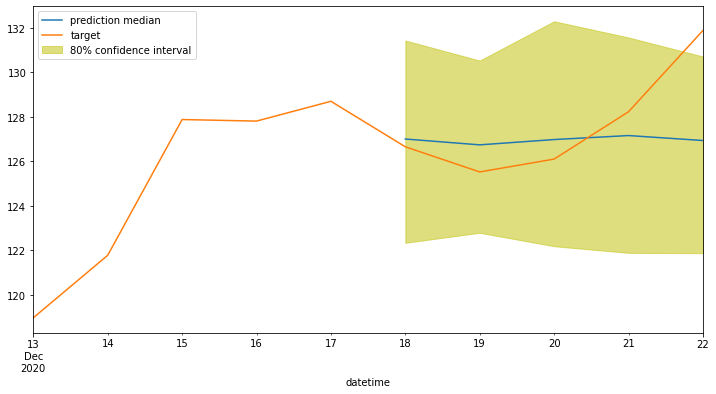

In [131]:
for k in range(len(list_of_df)):
    print (-prediction_length-context_length) #120 = 72+48
    plt.figure(figsize=(12,6))
    list_of_df[k]['0.5'].plot(label='prediction median')
    time_series_test[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
   # list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [132]:
predict_window = []

In [29]:
# Store the results
df_test[['count']].to_csv('prediction-with-dynamic-features.csv',index=True,index_label='datetime')

In [30]:
df_reg_cas[['count']].to_csv('prediction-with-dynamic-features-reg-cas.csv',index=True,index_label='datetime')

In [133]:
# Delete the endpoint after completing the demo...otherwise, your account will accumulate hourly charges
predictor.delete_endpoint()

In [ ]:
# Don't forget to terminate the end point after completing the demo
# Otherwise, you account will accumulate hourly charges

# you can delete from sagemaker management console or through command line or throught code

# predictor.delete_endpoint()